<a href="https://colab.research.google.com/github/alexchilton/CAS_Project/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import libraries

In [ ]:
%pip install tqdn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import LearningRateScheduler

# 2. Paths and constants

In [2]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# For Colab only_move to function file directory, load and go back to content /drive
%cd /content/drive/MyDrive/CAS_AML/function_files
import functions_m1_m2
%cd /content/drive

/content/drive/MyDrive/CAS_AML/function_files
/content/drive


In [4]:
DIR_TRAIN = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/train'
DIR_TEST = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/test'
DIR_VALIDATION = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/validation'
OUTPUT_DIR = '/content/drive/MyDrive/CAS_AML/outputs'


MODEL_LOCATION = '/content/drive/MyDrive/CAS_AML/models'

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 4. Transfer learning

## 4.1 ResNet50

### 4.1.1 Import model

In [7]:
from tensorflow.keras.applications import resnet50

In [8]:
model_rn50=tf.keras.applications.ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


### 4.1.2 Data preprocessing for ResNet50 (with data augmentation)

In [9]:
train_dir = DIR_TRAIN
validation_dir = DIR_VALIDATION

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2593 files belonging to 33 classes.


In [10]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 302 files belonging to 33 classes.


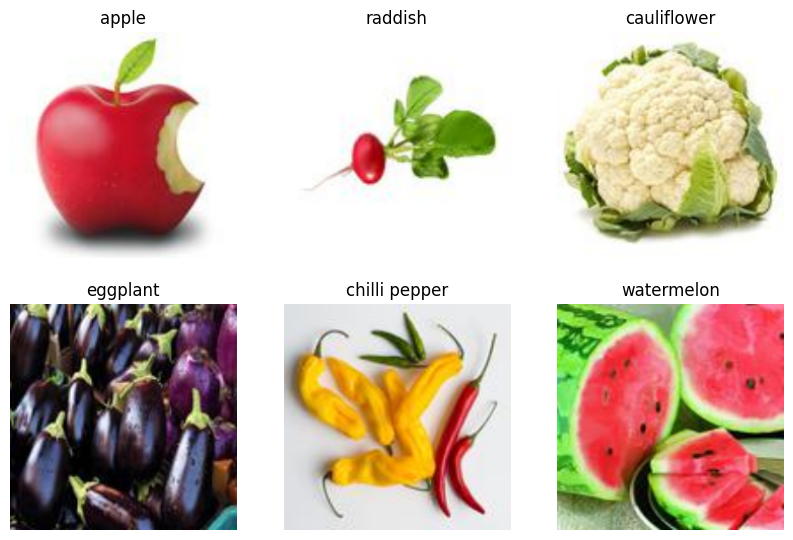

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 8
Number of test batches: 2


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


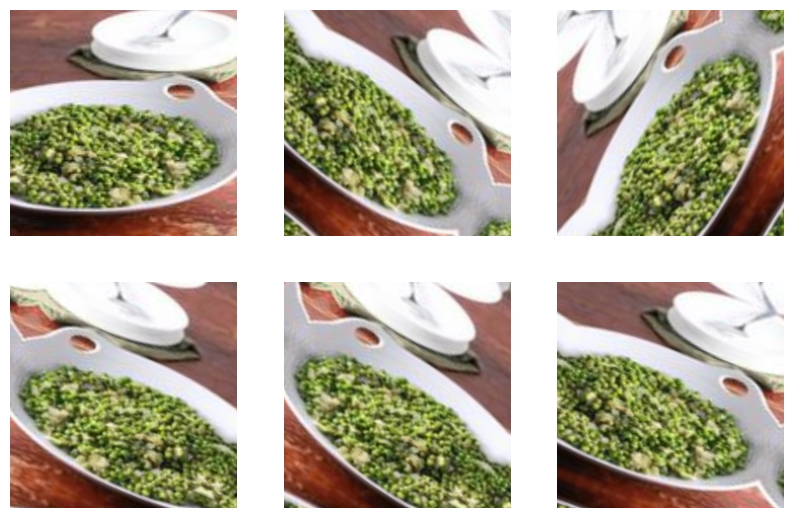

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [17]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [18]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


Feature extraction

In [20]:
base_model.trainable = False

In [21]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [35]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 33)


In [37]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [46]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_6[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[2][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 33)             │         67,617 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,655,329 (90.24 MB)

 Trainable params: 67,617 (264.13 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [47]:
len(model.trainable_variables)

2

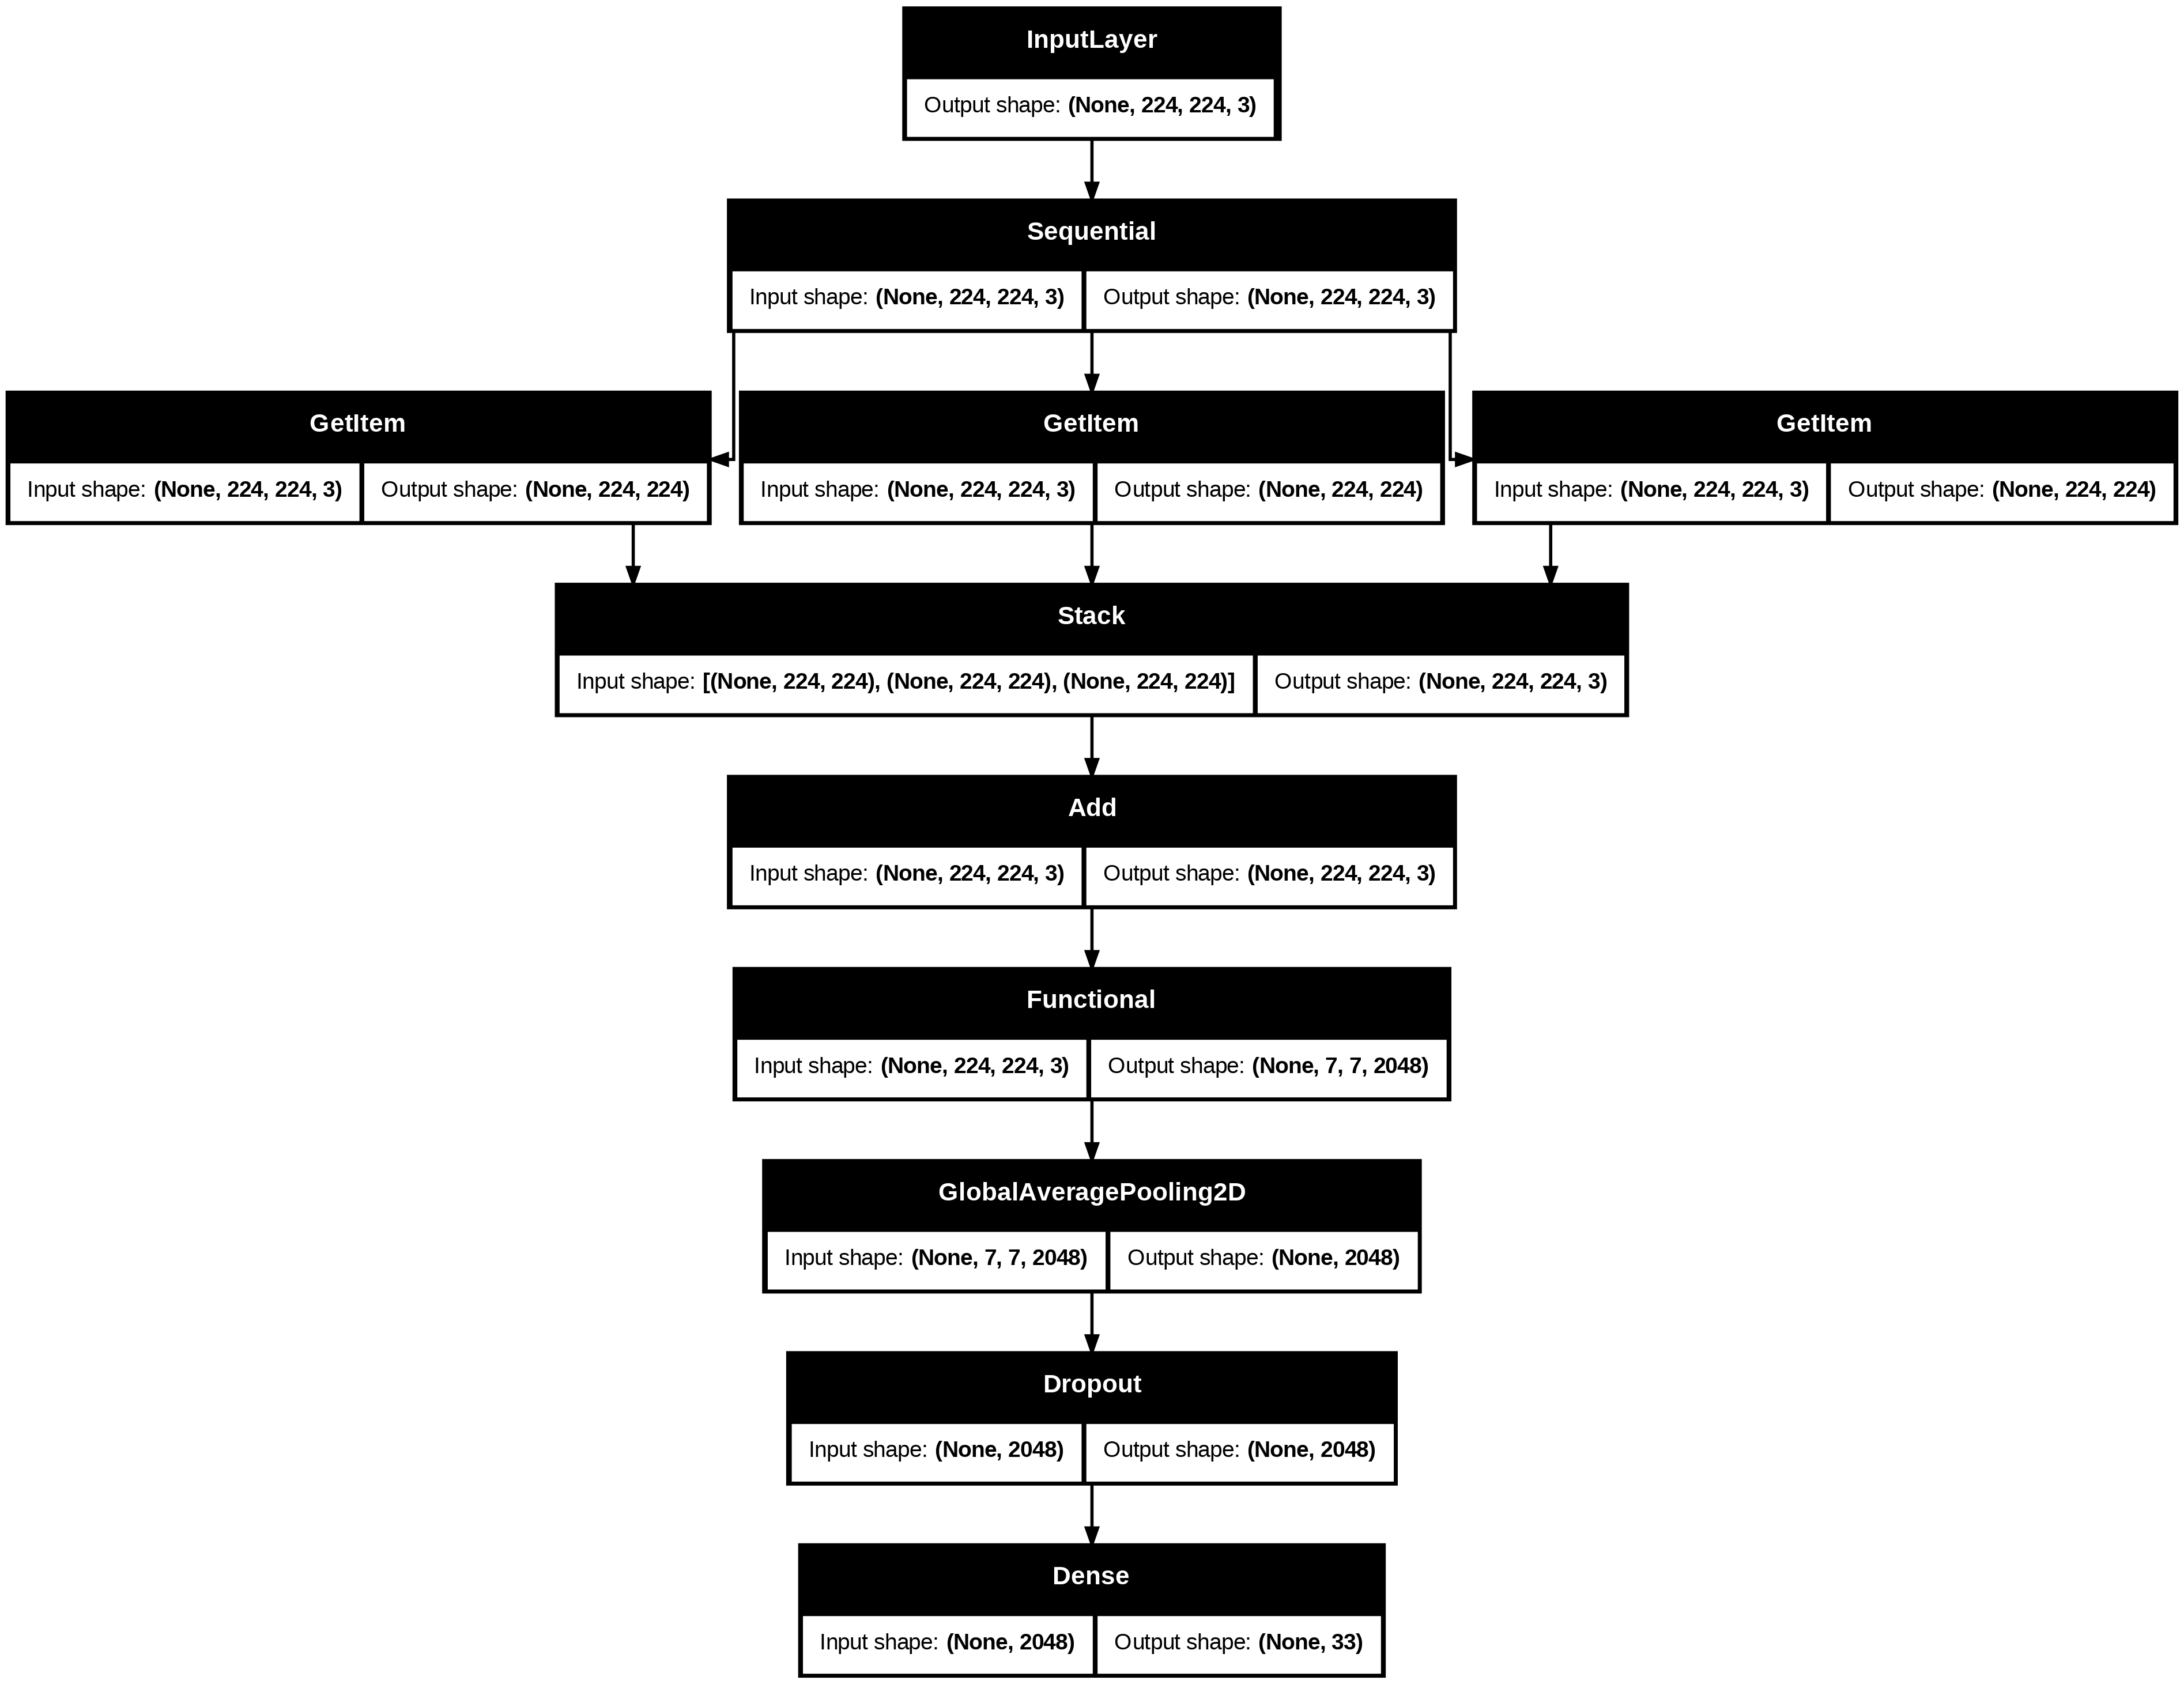

In [48]:
tf.keras.utils.plot_model(model, to_file='/content/model.png', show_shapes=True)
from IPython.display import Image
Image('/content/model.png')

In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


In [50]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0458 - loss: 4.1496


In [51]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.15
initial accuracy: 0.04


In [52]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.0784 - loss: 3.8578 - val_accuracy: 0.2899 - val_loss: 2.6608
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.2507 - loss: 2.7926 - val_accuracy: 0.5546 - val_loss: 1.9210
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4363 - loss: 2.1285 - val_accuracy: 0.6933 - val_loss: 1.4218
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5700 - loss: 1.6752 - val_accuracy: 0.7983 - val_loss: 1.0934
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6672 - loss: 1.3872 - val_accuracy: 0.8361 - val_loss: 0.8849
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7016 - loss: 1.1852 - val_accuracy: 0.8697 - val_loss: 0.6843
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7479 - loss: 1.0206 - val_accuracy: 0.8866 - val_loss: 0.6120
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7639 - loss: 0.9397 - val_accuracy: 0.8992 - v

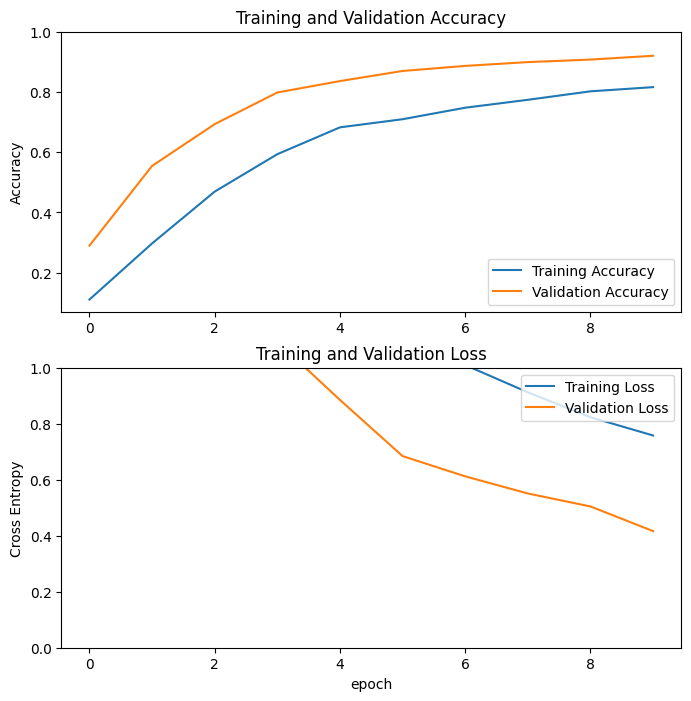

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Fine Tuning

In [55]:
base_model.trainable = True

In [56]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 143

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [58]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_6[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[2][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 33)             │         67,617 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,655,329 (90.24 MB)

 Trainable params: 15,043,617 (57.39 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [59]:
len(model.trainable_variables)

42

In [60]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.7569 - loss: 0.8861 - val_accuracy: 0.9538 - val_loss: 0.2833
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8457 - loss: 0.6233 - val_accuracy: 0.9706 - val_loss: 0.2189
Epoch 13/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8765 - loss: 0.5287 - val_accuracy: 0.9790 - val_loss: 0.1667
Epoch 14/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9035 - loss: 0.4357 - val_accuracy: 0.9832 - val_loss: 0.1141
Epoch 15/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9159 - loss: 0.3900 - val_accuracy: 0.9790 - val_loss: 0.1274
Epoch 16/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9138 - loss: 0.3515 - val_accuracy: 0.9832 - val_loss: 0.1082
Epoch 17/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9285 - loss: 0.3033 - val_accuracy: 0.9874 - val_loss: 0.0693
Epoch 18/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9239 - loss: 0.2868 - val_accuracy: 0

In [61]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

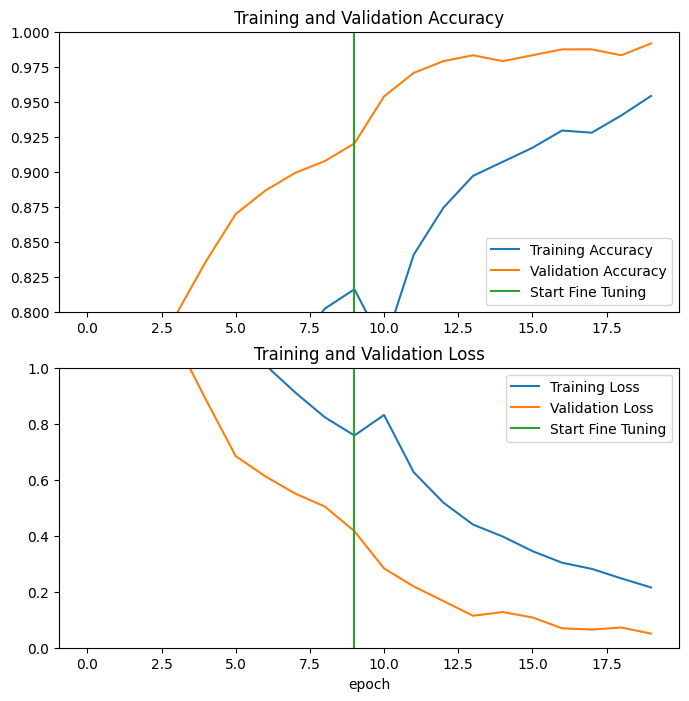

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [63]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0349
Test accuracy : 1.0


Predictions:
 [ 9 12 19  6  7 24 18 32 24 32 26  3  8  3 28 27 25  5 16 22  8 11 23  4
 12  6 16 26 28 22 15 12]
Labels:
 [ 9 12 19  6  7 24 18 32 24 32 26  3  8  3 28 27 25  5 16 22  8 11 23  4
 12  6 16 26 28 22 15 12]


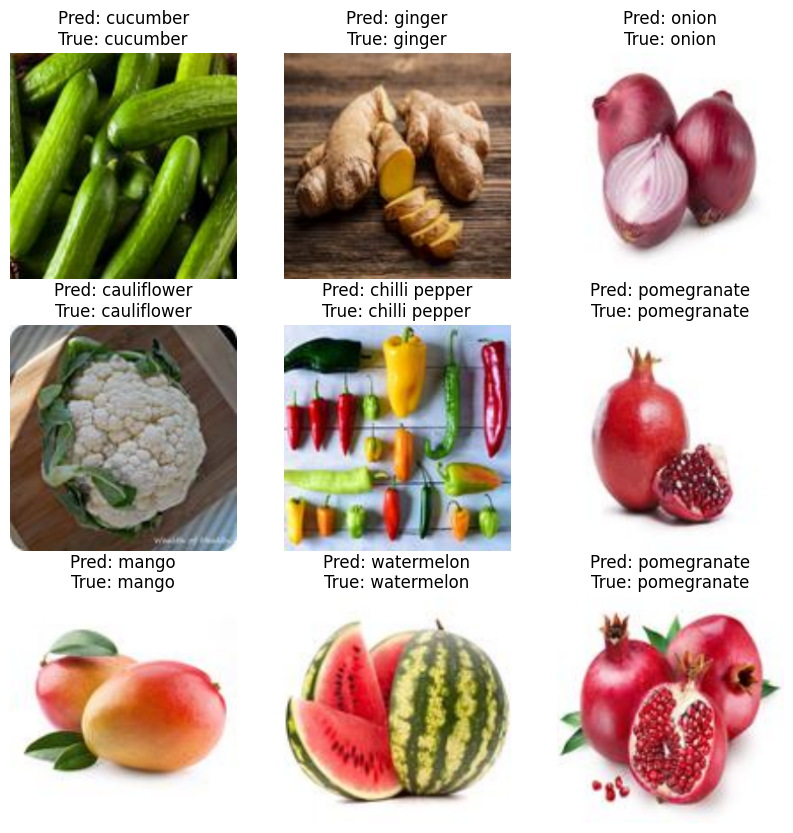

In [66]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Predict class probabilities for the batch
predictions = model.predict_on_batch(image_batch)  # Shape: (batch_size, num_classes)

# Convert probabilities to class predictions
predicted_classes = np.argmax(predictions, axis=-1)  # Shape: (batch_size,)

# Print predictions and labels
print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

# Display some of the images with their predicted and true labels
plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_batch))):  # Ensure you don't exceed the batch size
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[label_batch[i]]}")
    plt.axis("off")

plt.show()


## 4.2 Xception

### 4.2.1 Import model

Documentation:   
https://keras.io/api/applications/xception/

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
model_xcep=tf.keras.applications.Xception(weights='imagenet')

### 4.2.2 Data preprocessing for Xception

In [ ]:
class ImageLoader:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def load_image(self, image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)  # Ensure image has 3 channels
        return image, label

    def create_dataset(self, path, batch_size=1):
        # List all images and their labels
        class_names = sorted([d.name for d in os.scandir(path) if d.is_dir()])
        class_names_dict = dict(zip(class_names, range(len(class_names))))

        # Create a list of image file patterns for each class
        file_paths = []
        labels = []
        for class_name in class_names:
            class_path = os.path.join(path, class_name)
            file_pattern = os.path.join(class_path, '*.*')
            class_file_paths = [f for f in tf.io.gfile.glob(file_pattern)]
            file_paths.extend(class_file_paths)
            labels.extend([class_names_dict[class_name]] * len(class_file_paths))

        # Create a TensorFlow Dataset
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
        dataset = dataset.map(lambda x, y: self.load_image(x, y),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Shuffle, batch, and prefetch the dataset
        dataset = dataset.shuffle(buffer_size=len(file_paths))  # Shuffle the dataset
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for performance

        return dataset


In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

def preprocess_for_xception(image, label, augment=False):
    if augment:
        # Apply data augmentation only on the training set
        image = data_augmentation(image)

    # Check image values before preprocessing
    print("Image min before preprocessing:", tf.reduce_min(image).numpy())
    print("Image max before preprocessing:", tf.reduce_max(image).numpy())

    image = preprocess_input(image)  # Apply preprocessing as expected by Xception

    # Check image values after preprocessing
    print("Image min after preprocessing:", tf.reduce_min(image).numpy())
    print("Image max after preprocessing:", tf.reduce_max(image).numpy())

    return image, label


In [ ]:
# Confirm image channels are correctly handled
def check_image_channels(image):
    image = tf.image.decode_png(image, channels=3)
    print("Number of channels:", image.shape[-1].numpy())  # Should be 3


In [ ]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    ])

def preprocess_for_xception(image, label, augment=False):
    if augment:
      # Apply data augmentation only on training set
      image = data_augmentation(image)
      image = tf.keras.applications.xception.preprocess_input(image)
    else:
      image = tf.keras.applications.xception.preprocess_input(image)
    return image, label

def load_set(path, batch_size=32):
  loader=ImageLoader(width=299, height=299)  # Adapt basing on the model
  dataset=loader.create_dataset(path, batch_size=batch_size)
  return dataset

def get_preprocessed_dataset_xception(dataset, augment=False):
    dataset = dataset.map(lambda image, label: preprocess_for_xception(image, label, augment=augment),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
main_set=load_set(path=DIR_TRAIN, batch_size=32)

images = []
labels = []

for image_batch, label_batch in main_set:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

images = np.concatenate(images)
labels = np.concatenate(labels)

X_train, X_test, y_train, y_test = train_test_split(
    images, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
train_set = get_preprocessed_dataset_xception(dataset=train_set, augment=True)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
test_set = get_preprocessed_dataset_xception(dataset=test_set, augment=False)

TypeError: in user code:

    File "<ipython-input-48-74f915cd2c4e>", line 22, in None  *
        lambda image, label: preprocess_for_xception(image, label, augment=augment)
    File "<ipython-input-110-8f6c032e0f50>", line 13, in preprocess_for_xception  *
        image = tf.keras.applications.xception.preprocess_input(image)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/applications/xception.py", line 340, in preprocess_input  **
        return imagenet_utils.preprocess_input(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/applications/imagenet_utils.py", line 106, in preprocess_input
        return _preprocess_tensor_input(x, data_format=data_format, mode=mode)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/applications/imagenet_utils.py", line 257, in _preprocess_tensor_input
        x /= 127.5

    TypeError: `x` and `y` must have the same dtype, got tf.uint8 != tf.float32.


In [ ]:
train_size = train_set.cardinality().numpy() * 32
test_size = test_set.cardinality().numpy() * 32

print(f"Number of images in training set: {train_size}")
print(f"Number of images in test set: {test_size}")

Number of images in training set: 2080
Number of images in test set: 544


In [ ]:
random_images, random_labels = functions_m1_m2.select_random_images(train_set, num_images=5)

In [ ]:
class_names = sorted(os.listdir(DIR_TRAIN))
mapped_labels = [class_names[label] for label in random_labels]

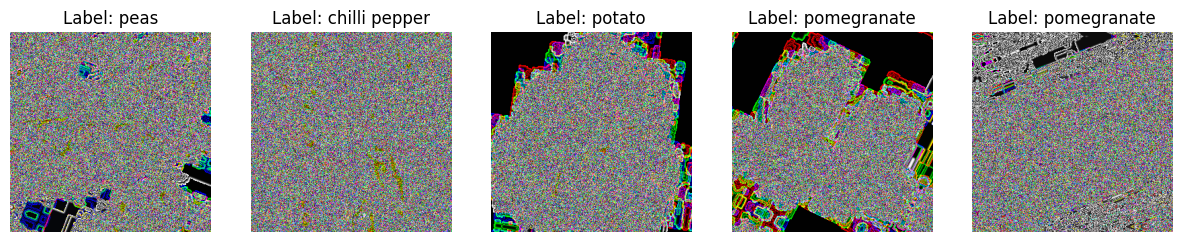

In [ ]:
functions_m1_m2.visualize_images(random_images, mapped_labels)


### 4.2.3 Transfer learning: top layers

In [ ]:
validation_set = test_set

In [ ]:
n_classes=len(class_names)
base_model=tf.keras.applications.Xception(weights='imagenet',
                                          include_top=False)
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(n_classes, activation='softmax')(avg)
model=tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.trainable=False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
CHECKPOINTS_PATH='/content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_xcep.keras'
checkpoint = ModelCheckpoint(
    CHECKPOINTS_PATH,
    save_best_only=True,      # Best model based on the validation loss
    monitor='val_loss',
    mode='min',
    verbose=2
)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=15,
    decay_rate=0.1
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=30,
    callbacks=[checkpoint],
    verbose=2
)

Epoch 1/30

Epoch 1: val_loss improved from inf to 243981.50000, saving model to /content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_xcep.keras
65/65 - 30s - 457ms/step - accuracy: 0.0444 - loss: 244154.9531 - val_accuracy: 0.0308 - val_loss: 243981.5000
Epoch 2/30

Epoch 2: val_loss improved from 243981.50000 to 242732.73438, saving model to /content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_xcep.keras
65/65 - 7s - 113ms/step - accuracy: 0.0526 - loss: 260912.6250 - val_accuracy: 0.0366 - val_loss: 242732.7344
Epoch 3/30

Epoch 3: val_loss improved from 242732.73438 to 242731.14062, saving model to /content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_xcep.keras
65/65 - 7s - 105ms/step - accuracy: 0.0535 - loss: 261875.3125 - val_accuracy: 0.0366 - val_loss: 242731.1406
Epoch 4/30

Epoch 4: val_loss did not improve from 242731.14062
65/65 - 6s - 92ms/step - accuracy: 0.0530 - loss: 258992.2656 - val_accuracy: 0.0366 - val_loss: 242731.1406
Epoch 5/30

Epoch 5: val_loss did not

In [ ]:
model = load_model(CHECKPOINTS_PATH)

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], label='Training loss')
if 'val_loss' in history_dict:
    plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['accuracy'], label='Training accuracy')
if 'val_accuracy' in history_dict:
    plt.plot(epochs, history_dict['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()